<img src='https://github.com/sentinel-hub/eo-learn/blob/master/docs/source/figures/eo-learn-logo.png' alt='eo-learn' width='300'/>

# CV4A ICRL Crop Type Classification Challenge
# A Guide to convert the data to eo-learn (EOPatches)

Credit: This notebook builds on top of [Notebook](https://github.com/radiantearth/mlhub-tutorials/blob/master/notebooks/2020%20CV4A%20Crop%20Type%20Challenge/cv4a-crop-challenge-visualize-s2-data.ipynb) prepared by Marc Rußwurm (marc.russwurm@tum.de)

Authors: Anže Zupanc, Devis Peressutti, EO Research Team, Sinergise eoresearch@sinergise.com

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import tifffile as tiff
import glob

from tqdm.auto import tqdm

from eolearn.core import EOPatch, FeatureType

### Set path to directory where data are stored

In [3]:
# location of directory to which data has been downloaded
ROOT_DATA_DIR = ''

L2A bands, last is cloud probability

In [4]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLD']

In [5]:
def load_file(fp):
    """Takes a PosixPath object or string filepath
    and returns np array"""
    return tiff.imread(fp.__str__())

def load_image(tile, date):
    img = list()
    for band in bands:
        file_name = f"{ROOT_DATA_DIR}/{tile}/{date}/{int(tile)}_{band}_{date}.tif"
        img.append(load_file(file_name))
    return np.dstack(img)

def load_timeseries(tile, dates):
    tstack = list()
    with tqdm(dates, total=len(dates), desc=f"reading images for tile {tile}") as pbar:
        for date in pbar:
            tstack.append(load_image(tile, date.strftime("%Y%m%d")))
    return np.stack(tstack) 

def load_label(tile):
    return tiff.imread(f'{ROOT_DATA_DIR}/{tile}/{tile[1]}_label.tif')

def load_field_id(tile):
    return tiff.imread(f'{ROOT_DATA_DIR}/{tile}/{tile[1]}_field_id.tif')

In [6]:
# Get a list of dates that an observation from Sentinel-2 is provided for from the currently downloaded imagery
tile_dates = {}
for f in glob.glob(f'{ROOT_DATA_DIR}/**/*.tif', recursive=True):
    if len(f.split('/')) != len(f'{ROOT_DATA_DIR}'.split('/'))+3:
        continue
    tile_id = f.split('/')[-3]
    date = datetime.datetime.strptime(f.split('/')[-2], '%Y%m%d')
    if tile_dates.get(tile_id, None) is None:
        tile_dates[tile_id] = []
    tile_dates[tile_id].append(date)

for tile_id, dates in tile_dates.items():
    tile_dates[tile_id] = list(set(tile_dates[tile_id]))

In [7]:
# All tiles have the same timestamps
for tile in tile_dates.keys():
    assert sorted(tile_dates['00']) == sorted(tile_dates[tile])

In [8]:
# Load a tile 

selected_tile = list(tile_dates.keys())[0]
dates = sorted(tile_dates[selected_tile])
timeseries = load_timeseries(selected_tile, dates)

print(f'Tile {selected_tile} imagery has shape [n_times, height, width, bands]: {timeseries.shape}')


Tile 03 imagery has shape [n_times, height, width, bands]: (13, 3035, 2016, 13)


## Convert to EOPatches

For practical reasons (reduce memory footprint) each tile will be sliced to 5x4 EOPatches.

In [9]:
h, w = timeseries.shape[1:3]
h_split = np.arange(0, h+1, int(h/5))
w_split = np.arange(0, w+1, int(w/4))

In [10]:
def save_as_eopatch(data, label, field_id, dates, folder):
    """
    Creates an EOPatch and adds data:
    * S2 L2A bands will be stored in DATA feature under name `S2-BANDS-L2A`
    * sen2cor cloud probabilities will be stored in DATA feature under name `CLOUD_PROB`
    * labels will be stored in MASK_TIMELESS under name `CROP_ID`
    * field ids  will be stored in MASK_TIMELESS under name `FIELD_ID`
    * dates of observations will be added to timestamps
    
    EOPatch is saved to specified folder.
    """
    eopatch = EOPatch()
    
    eopatch.add_feature(FeatureType.DATA, 'S2-BANDS-L2A', data[..., :12])
    eopatch.add_feature(FeatureType.DATA, 'CLOUD_PROB', data[..., -1][...,np.newaxis])
    eopatch.add_feature(FeatureType.MASK_TIMELESS, 'CROP_ID', label[...,np.newaxis])
    eopatch.add_feature(FeatureType.MASK_TIMELESS, 'FIELD_ID', field_id[...,np.newaxis])
    eopatch.timestamp = dates
    
    eopatch.save(folder)
    
    return eopatch

Split and save as `EOPatch` all tiles

In [11]:
eopatch_dir = f'{ROOT_DATA_DIR}/eopatches'

for tile in sorted(tile_dates.keys()):
    dates = sorted(tile_dates[tile])
    timeseries = load_timeseries(tile, dates)
    labels = load_label(tile)
    fields = load_field_id(tile)
    
    pbar = tqdm(total=(len(h_split)-1)*(len(w_split)-1), desc="Extracting and saving EOPatches")
    for hidx in range(0, len(h_split)-1):
        for widx in range(0, len(w_split)-1):
            eop_folder = f'{eopatch_dir}/eopatch-{tile}-{hidx}-{widx}'
            data = timeseries[:, h_split[hidx]:h_split[hidx+1], w_split[widx]:w_split[widx+1], :]
            label = labels[h_split[hidx]:h_split[hidx+1], w_split[widx]:w_split[widx+1]]
            field = fields[h_split[hidx]:h_split[hidx+1], w_split[widx]:w_split[widx+1]]
        
            save_as_eopatch(data, label, field, dates, eop_folder)
            pbar.update(1)

### Visualize a single EOPatch

In [12]:
eopatch_names = glob.glob(f'{eopatch_dir}/*')

In [28]:
eop_idx = 3
eop_name = eopatch_names[eop_idx].split('/')[-1]
eop = EOPatch.load(eopatch_names[eop_idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'FIELD_ID')

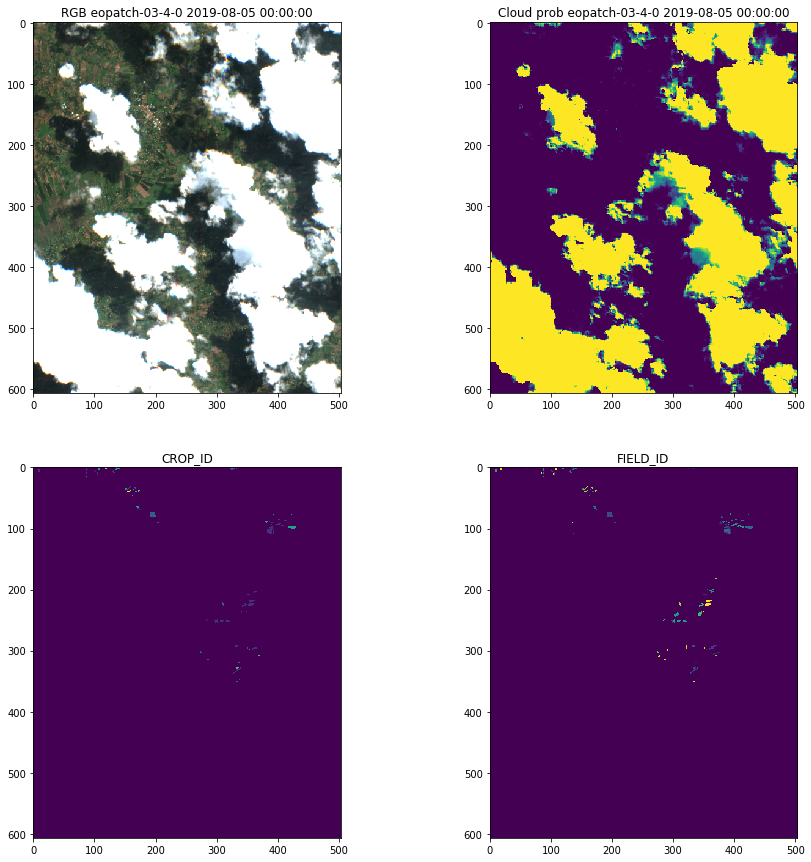

In [30]:
time_idx = 5

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

axs[0,0].imshow(np.moveaxis(eop.data['S2-BANDS-L2A'][time_idx,...,[3,2,1]],0,-1)*3.5)
axs[0,0].set_title(f'RGB {eop_name} {eop.timestamp[time_idx]}')
axs[0,1].imshow(eop.data['CLOUD_PROB'][time_idx].squeeze())
axs[0,1].set_title(f'Cloud prob {eop_name} {eop.timestamp[time_idx]}')

axs[1,0].imshow(eop.mask_timeless['CROP_ID'].squeeze())
axs[1,0].set_title(f'CROP_ID')
axs[1,1].imshow(eop.mask_timeless['FIELD_ID'].squeeze())
axs[1,1].set_title(f'FIELD_ID')

### Check what is the distribution of number of fields per patch

In [21]:
def get_field_count(eopatch):
    return len(np.unique(eopatch.mask_timeless['FIELD_ID']))-1

In [22]:
field_counts = []

for eopatch in eopatch_names:
    eop = EOPatch.load(eopatch, lazy_loading=True)
    name = eopatch.split('/')[-1]
    
    field_counts.append({'eopatch':name, 'field_count':get_field_count(eop)})

In [23]:
df = pd.DataFrame(field_counts)

In [24]:
df.head()

,eopatch,field_count
0,eopatch-03-1-0,8
1,eopatch-01-2-1,0
2,eopatch-02-2-1,0
3,eopatch-03-4-0,108
4,eopatch-00-0-0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94c0577320>]],
      dtype=object)

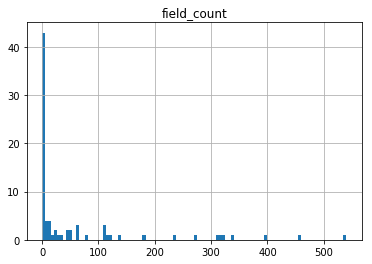

In [25]:
df.hist('field_count',bins=100)

In [26]:
print(f'Out of {len(eopatch_names)} eopatches {len(df.loc[df.field_count==0])} have no reference data and hence can be ignored in rest of the analysis.')

Out of 80 eopatches 40 have no reference data and hence can be ignored in rest of the analysis.


The sum of all fields over all EOPatches can be larger than overal number of fields, because same field can be split to two or more EOPatches.

In [27]:
df.field_count.sum()

4748